# Transformers for BoolQ reading comprehension
*All changes and additions compared to Stage 1 are marked in <span style="color: orange;">orange</span>*

## Sources

My sources for this project are linked in the respecting sections of the notebook. I used AI tools such as ChatGPT to correct my writing and grammar in stage 1 of this project and plan on using it for debugging during stage 2. Additionally, I used the `hyperparameter_tuing` notebook from the MLOPS course as a rough guide for the structure in this project.

## <span style="color: orange;">TLDR - Executive summary</span>
### **Topic:**
Implement and train a pre-trained Transformer model end to end for binary question answering on the BoolQ dataset from Hugging Face.

### **Data:**
The dataset is for reading comprehension and question answering tasks. It consists of questions, passages, and the corresponding yes/no answers, with separate training and test splits. For this project, the last 1000 entries of the training split were set aside to use as a validation split. Class imbalance was observed across the splits, with approximately 62% of samples labeled "yes".

### **Methods:**
The project involves preprocessing the data using the `AutoTokenizer` that instantiates the correct tokenizer with the pre-trained `bert-base-cased` model. Using the `[CLS]` token from bert-base-cased model output as the input for my two-layer classifier with ReLU and a dropout layer inbetween both layers to finally receive the binary output. 

### **Model:**
The model is based on a `bert-base-cased` model from Hugging Face and is structured as follows:
- **Bert Transformer**: Used without modification, with the training mode enabled.
- **Classifier**: A two-layer classifier with ReLU non-linearity and a dropout layer.
- **Loss Function**: Binary Cross-Entropy Loss `BCELoss`.

### **Experiments:**
Link to WandB: [Weights and Biases](https://wandb.ai/aintnoair/nlp-p4-pretrained_transformers/overview) <br>
Initial manual testing runs were conducted to verify the model’s functionality, followed by hyperparameter optimization using Optuna (5 trials due to time constraints). The ranges explored were:
- learning_rate: 1e-6, 1e-3
- hidden_dim: 64, 512, step=64
- dropout_rate: 0.0, 0.5
- weight_decay: 1e-6, 1e-2
- warmup_ratio: 0.0, 0.1 (percentage of total training steps)

### **Results:**
Key findings:
- The best model achieved a validation accuracy of **73.60%** and a test accuracy of **72.63%**, significantly outperforming the majority baseline test accuracy of **62.17%**.
-  model effectively addressed overfitting using a dropout rate of **0.2077** and weight decay of **7.37e-05**.
- A smaller `bert-base-cased` model, when fine-tuned with optimized hyperparameters, matched the larger `bert-large-cased` model, which achieved a test accuracy of **72.63%**. This highlights the importance of careful hyperparameter tuning over simply scaling up model size.
- Despite strong overall performance, the model showed a slight bias toward the majority "yes" class, attributed to the class imbalance in the dataset.


## Setup

### **Importing Python Packages**
Making sure the notebook is reproducible and runs without error, I will install the necessary libraries in a pip cell below.

### **Data Loading and Split**
The BoolQ dataset contains binary question-answer pairs. Each entry consists of a question, a passage, and the corresponding binary answer (yes/no). The dataset is split as required by the course materials:
- **Train Split:** The first 8427 entries of the training data.
- **Validation Split:** The last 1000 entries of the training data.
- **Test Split:** The validation split provided in the BoolQ dataset (3270 entries).

### **Seeding for Reproducibility**
A seed value of 42 is used to ensure reproducibility of results across different runs.

### **Batch size**
Setting the batch size in the beginning of the notebook for use throughout the code.
<span style="color: orange;">Also setting the maximum sequence length as well as the model name in the beginning of the notebook as these will not change during use.</span>

In [1]:
# TODO: install all necessary packages
# %pip install -q 

In [2]:
# TODO: import libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from typing import Any, Dict
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from sklearn.metrics import confusion_matrix
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
from optuna.integration import PyTorchLightningPruningCallback

import wandb


C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# TODO: set random seed to 42
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [4]:
# TODO: set constants for projects
BATCH_SIZE: int = 32
MAX_SEQ_LENGTH: int = 512
MODEL_NAME: str = "bert-base-cased"

print(f"Batch size: {BATCH_SIZE}"
      f"\nMax seq length: {MAX_SEQ_LENGTH}"
      f"\nModel Name: {MODEL_NAME}")

Batch size: 32
Max seq length: 512
Model Name: bert-base-cased


In [5]:
# Experimental data exploration: not really necessary for the project but done anyway.

train_data = load_dataset('google/boolq', split='train[:-1000]')
validation_data = load_dataset('google/boolq', split='train[-1000:]')
test_data = load_dataset('google/boolq', split='validation')

test_question = train_data[5]['question']
test_passage = train_data[5]['passage']
print(train_data[5])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")
print(f"Number of validation samples: {len(test_data)}")

train_yes_count = sum(1 for label in train_data['answer'] if label == 1)
train_no_count = sum(1 for label in train_data['answer'] if label == 0)
train_total = train_yes_count + train_no_count

validation_yes_count = sum(1 for label in validation_data['answer'] if label == 1)
validation_no_count = sum(1 for label in validation_data['answer'] if label == 0)
validation_total = validation_yes_count + validation_no_count

test_yes_count = sum(1 for label in test_data['answer'] if label == 1)
test_no_count = sum(1 for label in test_data['answer'] if label == 0)
test_total = test_yes_count + test_no_count

print(f"Train set (yes/no) Ratio: {round(train_yes_count / train_no_count, 2)}, Percent Yes: {round(train_yes_count / train_total * 100, 2)}%")

print(f"Validation set (yes/no) Ratio: {round(validation_yes_count / validation_no_count, 2)}, Percent Yes: {round(validation_yes_count / validation_total * 100, 2)}%")

print(f"Test set (yes/no) Ratio: {round(test_yes_count / test_no_count, 2)}, Percent Yes: {round(test_yes_count / test_total * 100, 2)}%")

{'question': 'can you use oyster card at epsom station', 'answer': False, 'passage': "Epsom railway station serves the town of Epsom in Surrey. It is located off Waterloo Road and is less than two minutes' walk from the High Street. It is not in the London Oyster card zone unlike Epsom Downs or Tattenham Corner stations. The station building was replaced in 2012/2013 with a new building with apartments above the station (see end of article)."}
Number of training samples: 8427
Number of validation samples: 1000
Number of validation samples: 3270
Train set (yes/no) Ratio: 1.68, Percent Yes: 62.64%
Validation set (yes/no) Ratio: 1.47, Percent Yes: 59.5%
Test set (yes/no) Ratio: 1.64, Percent Yes: 62.17%


## Preprocessing

### Tokenizer
In this project, the `AutoTokenizer` from the Hugging Face Transformers library is used to handle text preprocessing. Specifically, the `bert-base-cased` associated with the "bert-base-cased" model is instantiated. This tokenizer manages:
- Whitespace and special character removal.
- Retaining case sensitivity to preserve semantic meaning.
- Padding and truncation to ensure sequences are within the 512-token limit.

##### Tokenization Details
- **Questions:** The length of questions is capped at 21 tokens, based on dataset analysis.
- **Passages:** Passages are padded or truncated to ensure the overall sequence remains within the 512-token limit.


#### Handling OOV words
The BERT Tokenizer utilizes a WordPiece tokenization strategy. Words not present in the vocabulary are decomposed into subword units. For example, an unknown word like "unhappiness" might be tokenized into "un", "##happiness". This approach ensures that even unseen words are represented through known subword components.


#### Padding and Truncation
Sequences are padded to a maximum length of 512 tokens, aligning with BERT's architecture constraints. ~~Padding is applied to the maximum sequence length, not just the length of the longest sequence in a batch. This approach ensures consistent input dimensions across all batches, prioritizing simplicity and uniformity over computational efficiency. While dynamic batch padding could improve efficiency and reduce memory usage, the focus of this project is not on optimizing transformer models for efficiency. Therefore, fixed padding is used to streamline implementation and maintain uniformity.~~
<span style="color: orange;">Correction: I got dynamic padding working, so I implemented that to save on hardware resources and speed up training.</span>


#### Case Sensitivity
The "bert-base-cased" tokenizer is case-sensitive, distinguishing between words like "Apple" and "apple". This sensitivity preserves the semantic nuances of the text.


### Embedding Layer
The model leverages the pre-trained embeddings form the "bert-base-cased" model. These embeddings are fine-tuned during training to adapt to the specific nuances of the BoolQ dataset.


### Positional Embeddings
BERT inherently incorporates positional embeddings, unlike the transformer encoder in the last project, to capture the order of tokens in a sequence.


### Input / Output / Label Format
Each data point consists of a question, passage, and binary label (True/False). The preprocessing transforms these into the following formats:
- **Tokenization**:
    - *input*: Concatenated question and passage with `[CLS]` at the start, and `[SEP]` is placed between and at the end of the concatenated sequence.
    - *output*: Tokenized sequences with attention masks:
        - `input_ids`: Tensor of shape `(batch_size, sequence_length)`, representing token IDs.
        - `attention_mask`: Tensor of shape `(batch_size, sequence_length)`, indicating non-padded tokens.
- **Transformer Encoder**:
    - *input*: Tokenized `input_ids` and `attention_mask` tensors with shape `(batch_size, sequence_length)`.
    - *output*: Contextualized embeddings from the final encoder layer of shape `(batch_size, sequence_length, hidden_dim)`.
- **Classifier**:
    - *input*: The embedding corresponding to the `[CLS]` token with shape `(batch_size, hidden_dim)`.
    - *output*: A single logit per data point with shape `(batch_size, 1)`, representing the probability of the label being True.
- **Label format**:
    - Binary labels are encoded as integers (`0` for False, `1` for True).

In [6]:
class BoolQDataset(Dataset):
    def __init__(self, data: Dict[str, Any], tokenizer: AutoTokenizer, max_length: int = MAX_SEQ_LENGTH):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.data["question"])

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        # Get question and passage
        question = self.data["question"][idx]
        passage = self.data["passage"][idx]
        label = self.data["answer"][idx]

        # Tokenize
        encoded = self.tokenizer(
            question,
            passage,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # Correctness tests for tokenization
        assert encoded["input_ids"].shape[-1] <= self.max_length, "Token length exceeds max_length!"
        assert encoded["input_ids"].shape == encoded["attention_mask"].shape, "Mismatch in token shapes!"

        return {
            "input_ids": encoded["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": encoded["attention_mask"].squeeze(0),  # Remove batch dimension
            "label": torch.tensor(label, dtype=torch.float),  # Float for binary classification
        }

In [7]:
class BoolQDataModule(pl.LightningDataModule):
    def __init__(self, tokenizer_name: str, batch_size: int = BATCH_SIZE, max_length: int = MAX_SEQ_LENGTH):
        super().__init__()
        self.tokenizer_name = tokenizer_name
        self.batch_size = batch_size
        self.max_length = max_length

    def prepare_data(self) -> None:
        # Loading the dataset based on lecture slides
        self.train_data = load_dataset("google/boolq", split="train[:-1000]")
        self.validation_data = load_dataset("google/boolq", split="train[-1000:]")
        self.test_data = load_dataset("google/boolq", split="validation")

    def setup(self, stage: str = None) -> None:
        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_name)

        # Create datasets
        self.train_dataset = BoolQDataset(self.train_data, self.tokenizer, self.max_length)
        self.val_dataset = BoolQDataset(self.validation_data, self.tokenizer, self.max_length)
        self.test_dataset = BoolQDataset(self.test_data, self.tokenizer, self.max_length)

        # Test dataset length
        assert len(self.train_dataset) == 8427, "Train dataset length is incorrect!"
        assert len(self.val_dataset) == 1000, "Validation dataset length is incorrect!"
        assert len(self.test_dataset) == 3270, "Test dataset length is incorrect!"

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Initialize DataModule
data_module = BoolQDataModule(tokenizer_name=MODEL_NAME, batch_size=BATCH_SIZE)

# Prepare and test data loading
data_module.prepare_data()
data_module.setup()

# Correctness test for DataLoader
for batch in data_module.train_dataloader():
    assert batch["input_ids"].shape[0] == BATCH_SIZE, "Batch size mismatch!"
    print(f"Batch loaded successfully with shape: {batch['input_ids'].shape}")
    break



Batch loaded successfully with shape: torch.Size([32, 512])


## Model

### Architecture
- **Pretrained Transformer Encoder:**
  - Hugging Face’s `bert-base-cased` processes tokenized inputs.
  - The output corresponding to the `[CLS]` token is extracted as a fixed-size representation.
  - *The `bert-base-cased` model is pretrained using a masked language modeling and next sentence prediction objective and not question answering. This is why I deem it usable for this project where fine-tuned pretrained models are not allowed.*
- **Classifier:**
  - A two-layer fully connected network processes the `[CLS]` token embedding:
    - **First Layer:** Projects the embedding to the hidden dimension with ReLU activation.
    - **Dropout Layer:** Introduced after ReLU to reduce overfitting.
    - **Second Layer:** Maps the hidden representation to a single binary output using Sigmoid activation.


### Loss Function
The Binary Cross-Entropy Loss (BCE) function is used to calculate the difference between predicted and true labels for binary classification.


### Optimizer
*Learning rates stated here are for testing model functionality. Hyperparameters for experiments stated in `Experiments`.*
- **AdamW Optimizer:**
  - A learning rate of `2e-5` is used for the Transformer encoder.
  - A higher learning rate of `2e-4` is applied to the classifier layers to allow faster convergence.
  - <span style="color: orange;">These learning rates were only en example to demonstrate the classifier lr is 10x of the transformer lr.</span>


### Checkpointing and Early Stopping
- **Checkpointing:** Save the model with the best validation accuracy. Criteria for this will be the maximum validation accuracy.
- **Early Stopping:** Terminates training if validation loss does not improve for <span style="color: orange;">5</span> consecutive epochs.


### Correctness Tests
- **Tokenization**:
    - Ensure the tokenized output does not exceed 512 tokens.
    - Verify alignment between `input_ids` and `attention_mask` dimensions.

- **DataLoader**:
    - Verify batch size consistency during data loading.
    - Check that the output tensors for `input_ids` and `attention_mask` match the expected batch size and sequence length.

- **Model Input/Output**:
    - Confirm the input to the Transformer encoder has the shape `(batch_size, sequence_length)`.
    - Validate that the output of the Transformer encoder has the shape `(batch_size, sequence_length, hidden_dim)`.

- **Classifier Dimensions**:
    - Check that the input to the classifier corresponds to the `[CLS]` token embedding with shape `(batch_size, hidden_dim)`.
    - Ensure the output of the classifier has the shape `(batch_size, 1)`.

- **Reproducibility**:
    - Validate consistent results across multiple runs with the same random seed.


In [8]:
class BoolQClassifier(pl.LightningModule):
    def __init__(
            self,
            model_name: str,
            learning_rate: float = 1e-5,
            hidden_dim: int = 256,
            dropout_rate: float = 0.0,
            weight_decay: float = 1e-4,
            warmup_ratio: float = 0.1,  # Percentage of total steps
    ):
        super(BoolQClassifier, self).__init__()
        self.save_hyperparameters()
        self.bert = AutoModel.from_pretrained(model_name)
        self.bert.train()
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.loss_fn = nn.BCELoss()

        # Storage for confusion metrics
        self.validation_preds = []
        self.validation_labels = []
        self.test_preds = []
        self.test_labels = []

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(cls_output)
        return logits.squeeze(-1)

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()
        
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, Any]:
        self.bert.eval()
        
        with torch.no_grad():
            logits = self(batch['input_ids'], batch['attention_mask'])
        loss = self.loss_fn(logits, batch['label'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()
        
        self.validation_preds.extend(preds.cpu().numpy())
        self.validation_labels.extend(batch['label'].cpu().numpy())

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}
    
    def on_validation_epoch_end(self) -> None:
        cm = confusion_matrix(self.validation_labels, self.validation_preds)
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        plt.title("Validation Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        self.logger.experiment.log({"Validation Confusion Matrix": wandb.Image(fig)})
        plt.show()

        self.validation_preds.clear()
        self.validation_labels.clear()

    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, Any]:
        self.bert.eval()
        
        with torch.no_grad():
            logits = self(batch['input_ids'], batch['attention_mask'])
        preds = (logits > 0.5).float()
        acc = (preds == batch['label']).float().mean()

        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(batch['label'].cpu().numpy())

        self.log('test_acc', acc, prog_bar=True)
        return {}

    def on_test_epoch_end(self) -> None:
        cm = confusion_matrix(self.test_labels, self.test_preds)
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        plt.title("Test Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()

        self.logger.experiment.log({"Test Confusion Matrix": wandb.Image(fig)})
        plt.show()

        self.test_preds.clear()
        self.test_labels.clear()

    def configure_optimizers(self):
        
        transformer_params = list(self.bert.parameters())
        classifier_params = list(self.classifier.parameters())
    
        transformer_lr = self.hparams.learning_rate  # Base learning rate
        classifier_lr = self.hparams.learning_rate * 10  # Higher learning rate for classifier
    
        optimizer = torch.optim.AdamW([
            {'params': transformer_params, 'lr': transformer_lr},
            {'params': classifier_params, 'lr': classifier_lr}
        ])
        
        # Total steps calculation (approximation for one epoch)
        total_steps = (
            len(self.trainer.datamodule.train_dataloader())
            * self.trainer.max_epochs
        )
        warmup_steps = int(total_steps * self.hparams.warmup_ratio)

        # Scheduler
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1,
        }
        
        return [optimizer], [scheduler]


## Experiments
**Batch Size:** I will start with a batch_size of 16 and increase it to the maximum my hardware can handle then leaving it fixed as it is not a hyperparameter.


### Hyperparameters
The following hyperparameter ranges were explored during tuning:
- **Learning Rate:** `[1e-3, 1e-6]` -> The learning rate for the classifier will be 10x the transformer learning rate, as described in the optimizer section.
- **Classifier Hidden Dimension:** `[64, 512]`
- **Dropout Rate:** `[0.1, 0.3]`
- **Weight Decay:** `[1e-4, 1e-6]`
- **Warmup Steps:** `[0.0, 0.1]` in % of total number of steps


### Training Strategy
For testing the model will be run with manually set hyperparameters. In a second stage the model will utilize optuna to automatically find the optimal hyperparameter combination.
- **Epochs:** A maximum of ~~100~~ <span style="color: orange;">10</span> epochs is set, with early stopping enabled. <span style="color: orange;">This has been adjusted due to training times per epoch.</span>
- **Warmup Steps:** 0-10% warmup steps improved convergence in prior transformer projects during training. Will test with and without warmup.


### Metrics
- **Validation Accuracy:** To evaluate model performance across different hyperparameter configurations, I will use validation accuracy as the primary metric.
- **Confusion Matrix:** This will give a comprehensive view of true positives, true negatives, false positives, and false negatives, allowing me deeper insight into the model’s performance.


### Logging
Weights and Biases (WandB) is used for experiment tracking, logging metrics such as train and validation loss, accuracy, and confusion matrices.


In [9]:
# Helper Function to Format Run Name
def format_run_name(hyperparams: dict) -> str:
    return "_".join([f"{key[:2]}_{val}" for key, val in hyperparams.items()])

# Manual Training
def train_manual():
    # Hyperparameters - best optuna hyperparameters filled out
    hyperparameters = {
        "learning_rate": 3.233413438380264e-05,
        "hidden_dim": 448,
        "dropout_rate": 0.20766842736826918,
        "weight_decay": 7.370027643649387e-05,
        "warmup_ratio": 0.08159326264046585,
        "model_name": MODEL_NAME,
        "batch_size": BATCH_SIZE,
        "patience": 5,
        "epochs": 10,
    }

    run_name = format_run_name(hyperparameters)

    wandb_logger = WandbLogger(
        project="nlp-p4-pretrained_transformers",
        name=run_name,
        group="best_optuna_run",
        log_model=True,
        reinit=True,
    )

    data_module = BoolQDataModule(
        tokenizer_name=MODEL_NAME, 
        batch_size=hyperparameters["batch_size"]
    )

    model = BoolQClassifier(
        model_name=MODEL_NAME,
        learning_rate=hyperparameters["learning_rate"],
        hidden_dim=hyperparameters["hidden_dim"],
        dropout_rate=hyperparameters["dropout_rate"],
        weight_decay=hyperparameters["weight_decay"],
        warmup_ratio=hyperparameters["warmup_ratio"]
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=hyperparameters["patience"], mode='min')
    checkpoint = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, filename="best_optuna_run")

    trainer = Trainer(
        max_epochs=hyperparameters["epochs"],
        callbacks=[early_stopping, checkpoint],
        accelerator='auto',
        devices=1,
        logger=wandb_logger
    )

    trainer.fit(model, datamodule=data_module)
    
    wandb.finish()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aintnoair. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | bert       | BertModel  | 108 M  | train
1 | classifier | Sequential | 344 K  | train
2 | loss_fn    | BCELoss    | 0      | train
--------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
434.621   Total estimated model params size (MB)
235       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

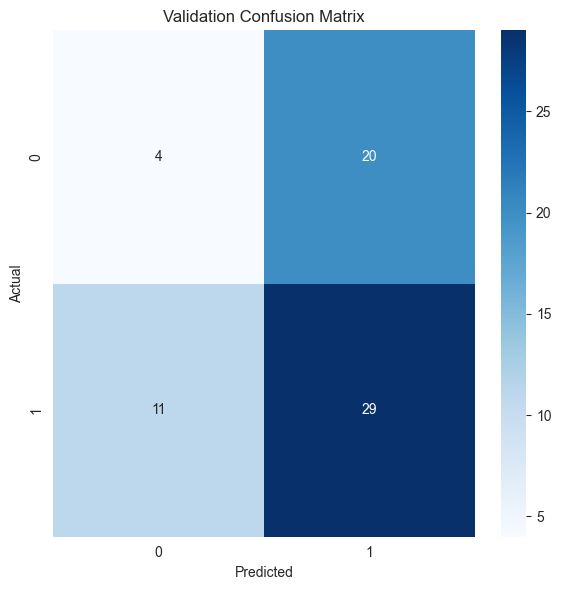

C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=7wld]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]

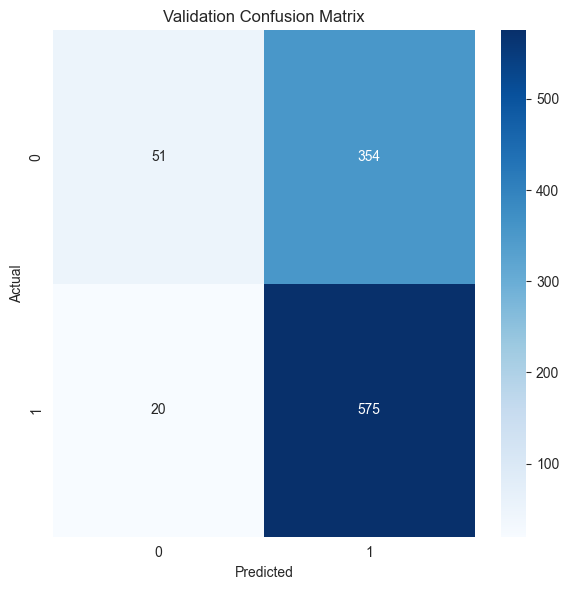


Epoch 1: 100%|██████████| 264/264 [03:52<00:00,  1.14it/s, v_num=7wld, val_loss=0.660, val_acc=0.626]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]

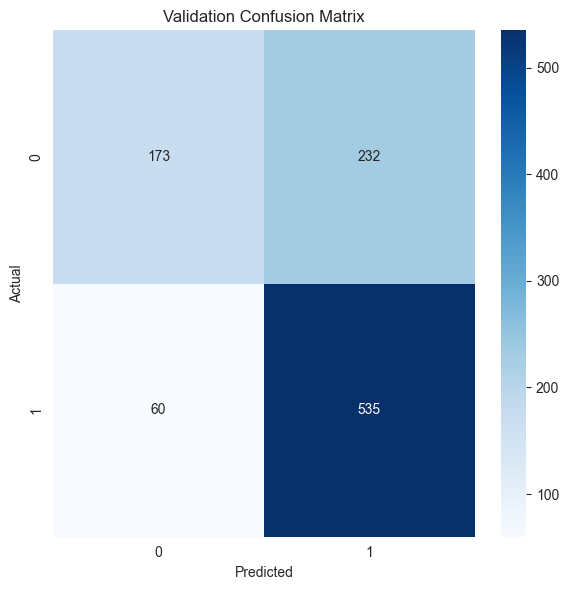


Epoch 2: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=7wld, val_loss=0.594, val_acc=0.708]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]

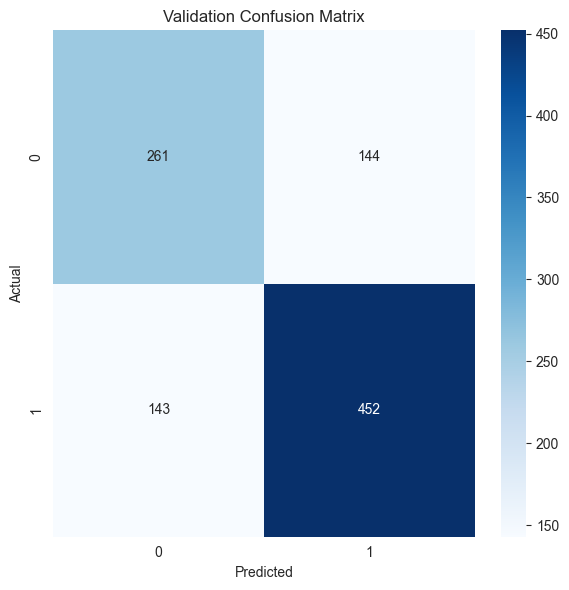


Epoch 3: 100%|██████████| 264/264 [03:54<00:00,  1.13it/s, v_num=7wld, val_loss=0.569, val_acc=0.713]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]

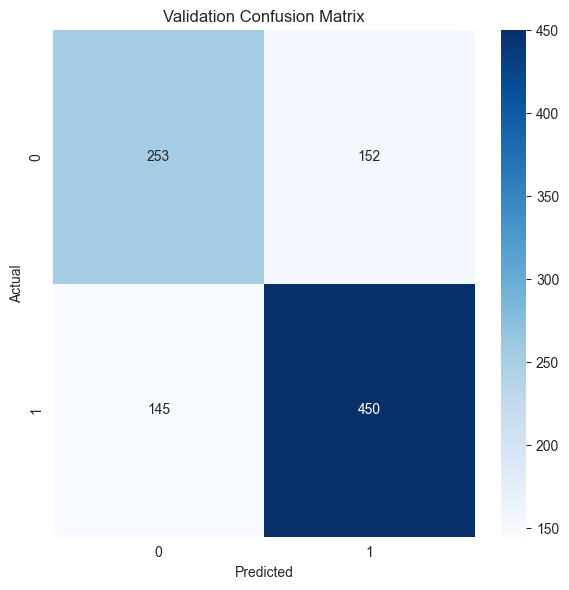


Epoch 4: 100%|██████████| 264/264 [03:56<00:00,  1.11it/s, v_num=7wld, val_loss=0.806, val_acc=0.703]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]

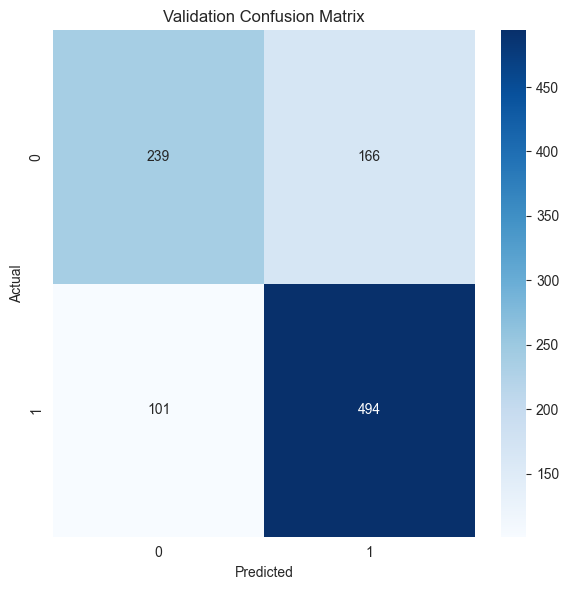


Epoch 5: 100%|██████████| 264/264 [03:56<00:00,  1.12it/s, v_num=7wld, val_loss=1.090, val_acc=0.733]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]

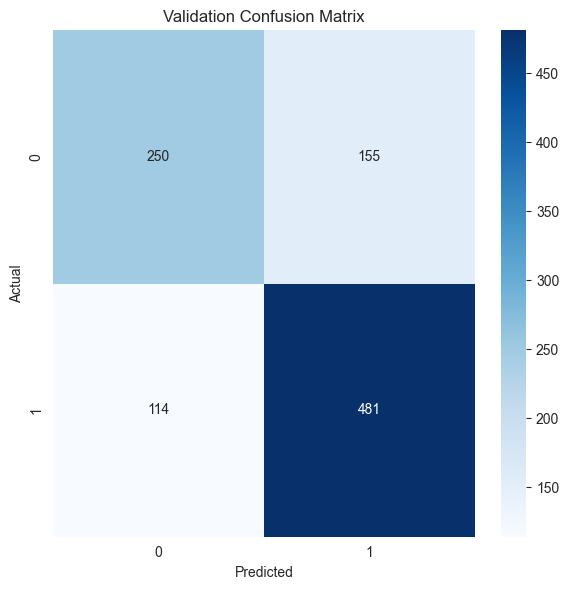


Epoch 6: 100%|██████████| 264/264 [03:56<00:00,  1.12it/s, v_num=7wld, val_loss=1.400, val_acc=0.731]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]

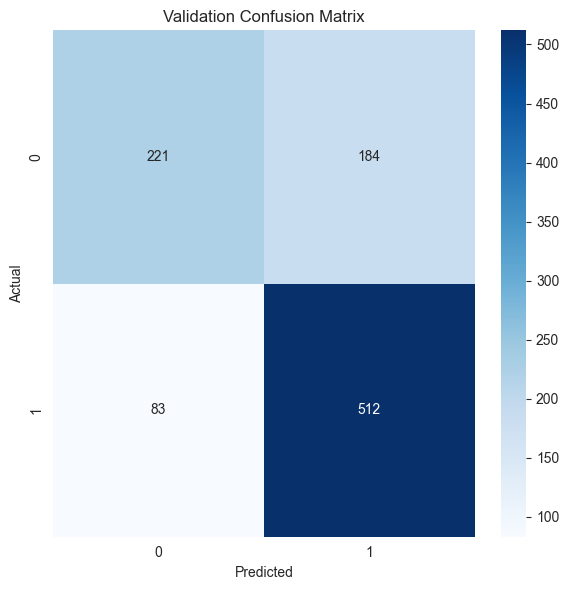


Epoch 7: 100%|██████████| 264/264 [03:53<00:00,  1.13it/s, v_num=7wld, val_loss=1.480, val_acc=0.733]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]

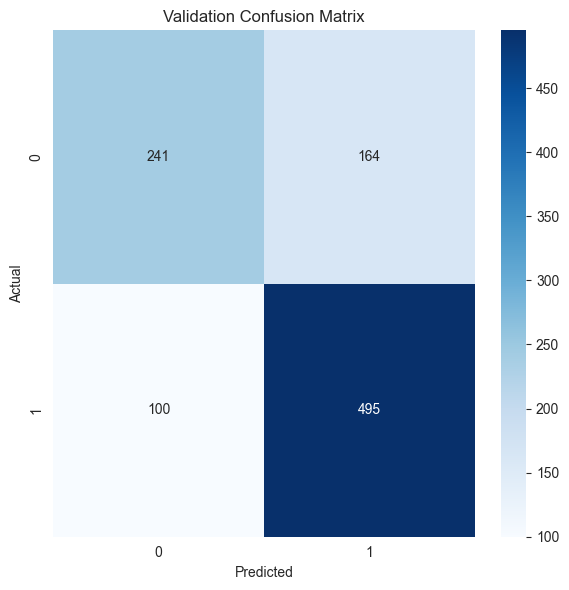


Epoch 7: 100%|██████████| 264/264 [04:06<00:00,  1.07it/s, v_num=7wld, val_loss=1.640, val_acc=0.736]


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_acc_epoch,▁▂▄▆▇███
train_acc_step,▃▄▁▄▄▅▆▄▄▅▆▆▆▅▅▇▇▆▆▇▇█▇▇▇█▇███████▇█████
train_loss_epoch,█▇▅▃▂▁▁▁
train_loss_step,▇▇█▇▇▆▆▆▇▆▅▆▅▆▆▃▃▄▄▄▂▂▃▃▃▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_acc,▁▆▇▆████
val_loss,▂▁▁▃▄▆▇█
epoch,7
train_acc_epoch,0.99264
train_acc_step,1


In [10]:
train_manual()

In [11]:
def objective(trial: optuna.Trial):
    hyperparameters = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-3),
        "hidden_dim": trial.suggest_int("hidden_dim", 64, 512, step=64),
        "dropout_rate": trial.suggest_uniform("dropout_rate", 0.0, 0.5),
        "weight_decay": trial.suggest_loguniform("weight_decay", 1e-6, 1e-2),
        "warmup_ratio": trial.suggest_uniform("warmup_ratio", 0.0, 0.1),
        "batch_size": BATCH_SIZE,
        "patience": 5,
        "epochs": 10,
    }
    
    run_name = format_run_name(hyperparameters)
    
    logger = WandbLogger(
        project="nlp-p4-pretrained_transformers",
        name=run_name,
        group="optuna",
        log_model=True,
        reinit=True,
    )
    
    data_module = BoolQDataModule(
        tokenizer_name=MODEL_NAME,
        batch_size=hyperparameters["batch_size"],
    )
    
    model = BoolQClassifier(
        model_name=MODEL_NAME,
        learning_rate=hyperparameters["learning_rate"],
        hidden_dim=hyperparameters["hidden_dim"],
        dropout_rate=hyperparameters["dropout_rate"],
        weight_decay=hyperparameters["weight_decay"],
        warmup_ratio=hyperparameters["warmup_ratio"]
    )
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=hyperparameters["patience"], mode="min")
    checkpoint = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1, filename=run_name)
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    
    trainer = Trainer(
        max_epochs=hyperparameters["epochs"],
        callbacks=[early_stopping, checkpoint, pruning_callback],
        accelerator="auto",
        devices=1,
        logger=logger
    )
    
    try:
        trainer.fit(model, datamodule=data_module)

        val_acc = trainer.callback_metrics.get("val_acc")
        if val_acc is not None:
            return val_acc.item()
        else:
            return 0.0
    finally:
        wandb.finish()
    
    
    
def run_optuna():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=5)

    print("Best hyperparameters:", study.best_params)
    print("Best value:", study.best_value)

    wandb_logger = WandbLogger(
        project="nlp-p4-pretrained_transformers",
        name="optuna_best",
        group="optuna",
        reinit=True,
    )
    wandb_logger.experiment.log({"best_params": study.best_params, "best_value": study.best_value})
    wandb.finish()


In [12]:
# run_optuna()

## Evaluation
The percentage of yes answers in each data split is: Train; 62.64%, Val; 59.50%, Test;62.17%
Seeing how difficult it was in past projects to reach a much better accuracy than the baseline majority class I am setting my goal for the pretrained BERT model at 64% accuracy on the test set.


### Error Analysis
To understand why the model may fail on certain predictions, I will conduct an error analysis investigating weather miss classifications are related to the confidence score the model has in its predictions. Low confidence on correct answers or high confidence on wrong answers may indicate areas where the model is uncertain or overconfident.


### Confusion Matrix
After the validation step, a confusion matrix is computed to assess true positives, false positives, true negatives, and false negatives. This provides insights into the model's prediction performance.


## Planned Correctness Tests
- Visually checking for decreasing loss during training.
- Verifying predictions with a confusion matrix.


## <span style="color: orange;">Evaluation</span>
Opting to forego manual preprocessing and instead utilizing the built-in functionality of the AutoTokenizer module to manage padding, truncation, extra whitespace removal, special character handling, and case sensitivity proved successful. This approach simplified the implementation and minimized the risk of errors.

### Data Imbalance Analysis
An exploration of the dataset revealed a significant class imbalance across the training, validation, and test sets. The proportion of "yes" labels is consistently higher across all splits:

Training set: 62.64% "yes" (1.68 ratio)
Validation set: 59.5% "yes" (1.47 ratio)
Test set: 62.17% "yes" (1.64 ratio)
This imbalance likely contributed to the model's tendency to predominantly predict the majority "yes" class, especially in the early stages of training. Without adjustments to address this imbalance, the model achieved a validation accuracy of approximately XXXXXXX% but failed to learn nuanced patterns in the minority "no" class.

To address this, I incorporated dropout, weight decay, and adjusted the learning rate during training. Additionally, I experimented with hyperparameter tuning using Optuna to optimize the model's performance further.

### Error and Confusion Matrix Analysis
The best-performing model from the Optuna trials achieved a validation accuracy of **73.60%** and a test accuracy of **72.63%**, significantly outperforming the baseline test accuracy of **62.17%**. The final model's run parameters were as follows:

- Run name: `le_3.233413438380264e-05_hi_448_dr_0.20766842736826918_we_7.370027643649387e-05_wa_0.08159326264046585_ba_32_pa_5_ep_10`
    - Learning rate: 3.23e-05
    - Hidden dimension: 448
    - Dropout rate: 0.2077
    - Weight decay: 7.37e-05
    - Warmup steps: 8.16%
    - Batch size: 32
    - Patience: 5 epochs
    - Max epochs: 10

Analysis of the confusion matrix revealed that while the model improved in predicting the minority "no" class compared to earlier runs, a slight bias toward the majority "yes" class persisted. This suggests that further techniques, such as weighted loss functions or oversampling the minority class, could enhance performance further. It was also interesting to see how the model improved over time when plotting the validation confusion matrix every epoch.

### Training Accuracy and Overfitting
The model reached a training accuracy of approximately 98.9% within 5–6 epochs, highlighting its capacity to fit the training data effectively. However, the gap between training and validation accuracy persisted, indicating some degree of overfitting despite applying dropout and weight decay.

### Comparison of BERT Models
The `bert-base-cased` model tuned with Optuna matched the "Hail Mary" `bert-large-cased` model, which achieved a validation accuracy of 72.60% and a test accuracy of 72.63%. Surprisingly, the smaller model not only matched but slightly surpassed the larger model's test performance, all while being significantly faster and more resource-efficient to train. This result emphasizes the importance of fine-tuning and hyperparameter optimization over simply scaling up model size.

### Evaluation on the test set
The final model achieved a test accuracy of **72.63%**, marking a substantial improvement over the baseline of **62.17%**. While the model's performance is promising, the persistent imbalance in predictions suggests room for further optimization.

### Recommendations for Future Projects
To further address the class imbalance, future iterations could explore:

- **Weighted Loss Functions**: Assigning higher weights to the minority "no" class to encourage the model to learn its patterns more effectively.
- **Focal Loss**: Adjusting the loss function to focus more on harder-to-classify examples.
Additionally, incorporating adversarial training or experimenting with ensemble methods could help the model better generalize to unseen data. Despite its limitations, the fine-tuned bert-base-cased model demonstrates promising performance and efficiency for the BoolQ dataset.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Pascal\miniconda3\envs\nlp\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 103/103 [00:49<00:00,  2.08it/s]

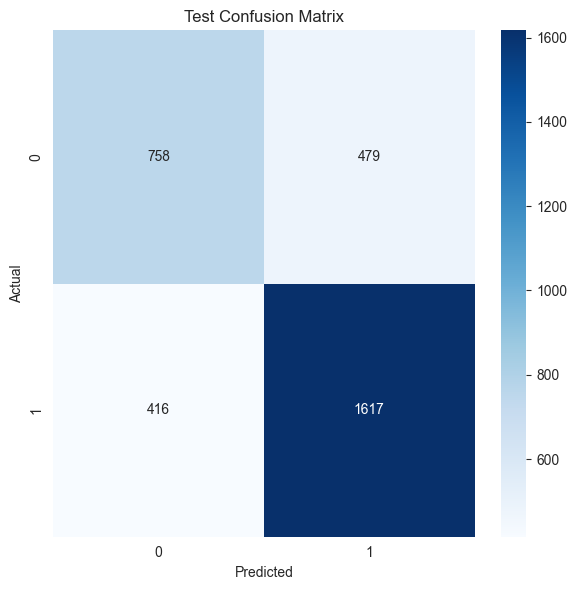

Testing DataLoader 0: 100%|██████████| 103/103 [00:49<00:00,  2.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7262997031211853
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁
test_acc,▁
trainer/global_step,▁▁
epoch,0
test_acc,0.7263
trainer/global_step,0


In [14]:
run_name = "best_optuna_run"
file_path = f"nlp-p4-pretrained_transformers/0ng67wld/checkpoints/{run_name}.ckpt"

model = BoolQClassifier.load_from_checkpoint(file_path)
logger = WandbLogger(
    project="nlp-p4-pretrained_transformers",
        name=run_name,
        group="optuna_test",
        reinit=True,
)

trainer = Trainer(logger=logger)

trainer.test(model, datamodule=data_module)

wandb.finish()

## Interpretation

My last project went decently well, beating the majority class accuracy of 62.17% on the test set. Before writing this interpretation I toyed around with the `bert-large-cased` model, implementing and running it as quickly as possible just to see what it could do. With 333 Million parameters in the transformer model I had to use a `batch_size` of 16 to not run out of memory. Giving it a single run over the weekend, with "looks about right" choice for hyperparameters, it managed to reach a test accuracy of 72.63% after over 23 hours of runtime. Impressed by this result I am setting my expectations for the properly implemented and fine-tuned `bert-base-cased` model to reach a test accuracy of 69%. Nice.

## <span style="color: orange;">Interpretation</span>
Before beginning this project, I set my expectations for the `bert-base-cased` model to reach a test accuracy of around **69%**, based on my preliminary "Hail Mary" run with the `bert-large-cased` model, which achieved a test accuracy of **72.63%**. To my surprise, the fine-tuned bert-base-cased model not only met but exceeded these expectations, achieving a validation accuracy of **73.60%** and a test accuracy of **72.63%**.

This result demonstrates that a smaller, well-tuned model can match or outperform a larger model on tasks like BoolQ, where dataset size and complexity may not fully leverage the additional capacity of a large model. The ability to fine-tune the base model with limited computational resources and achieve comparable results to the bert-large-cased model, which has 333 million parameters, highlights the efficiency of proper hyperparameter tuning.

One key takeaway from this project is the importance of addressing dataset imbalances. While the model performed admirably overall, the persistent bias toward the majority "yes" class suggests that the imbalanced label distribution limited its ability to fully capture patterns in the minority "no" class. Techniques such as class weighting, focal loss, or oversampling could be valuable avenues for future improvement.

Ultimately, this project showcased the power of fine-tuning smaller models and the significant impact of systematic hyperparameter optimization. While there is still room for improvement in mitigating overfitting and handling class imbalance, the results are a strong step forward in tackling the BoolQ dataset with pretrained Transformers.